In [ ]:
2!pip install -q -U keras-tuner # ML experiments aka hyparam tuning 

     |████████████████████████████████| 96 kB 4.2 MB/s 


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# Utility function 
def prepare_image(img_path, img_size = 150):
   img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))
   img_array = tf.keras.preprocessing.image.img_to_array(img)
   img_array_expanded_dims = np.expand_dims(img_array, axis=0)
   return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [4]:
import numpy as np  
import tensorflow as tf 
from tensorflow.keras.metrics import Precision , Recall 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt 
from tensorflow.keras.callbacks import EarlyStopping , LearningRateScheduler    
from tensorflow.keras.layers import Dense, Embedding, Input , Dropout, Conv1D , MaxPooling1D, Flatten , GlobalAveragePooling2D , Concatenate , BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping , LearningRateScheduler , ModelCheckpoint
from tensorflow.keras.models import Model
import seaborn as sns
from sklearn.metrics import classification_report
tf.random.set_seed(23) 
import pathlib

In [9]:
data_dir = pathlib.Path('/content/drive/MyDrive/BA885 Team Project/Labeled')
print('Total number of labeled images:', len(list(data_dir.glob('*/*.jpg'))))

train_ds_labeled = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=885,
  image_size=(150,150),
  batch_size=32,
  label_mode='categorical')


val_ds_labeled = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=885,
  image_size=(150,150),
  batch_size=32, 
  label_mode='categorical')


Total number of labeled images: 13151
Found 13151 files belonging to 6 classes.
Using 10521 files for training.
Found 13151 files belonging to 6 classes.
Using 2630 files for validation.


In [ ]:
def model_builder(hp):
        # Here we are defining what variables to go through in search space. 

        vgg19 = tf.keras.applications.vgg19.VGG19(input_shape=(224,224,3),
                  include_top=False, weights='imagenet')
        vgg19.trainable = False 
        # Hyperparameters that we are going to tune 

        hp_units = hp.Int('units',min_value=256,max_value=1024,step=128)
        hp_units2 = hp.Int('units2',min_value=256,max_value=1024,step=128)
        hp_units3 = hp.Int('units3',min_value=256,max_value=1024,step=128)
        
        
        hp_dropout = hp.Float('rate',min_value=.1,max_value=.6,step=.1)
        hp_dropout2 = hp.Float('rate2',min_value=.1,max_value=.6,step=.1)
      
        hp_activation1 = hp.Choice('activation',['relu','elu','selu'])
        hp_activation2 = hp.Choice('activation1',['relu','elu','selu'])
        hp_activation3 = hp.Choice('activation2',['relu','elu','selu'])
        hp_optimizer = hp.Choice('optimizers',['adam','rmsprop'])

        # model`` 
        input1  = Input((224,224,3))
        vgg19 = vgg19(input1)
        flat = Flatten()(vgg19)
        dense1 = Dense(hp_units,activation=hp_activation1)(flat)
        dropout = Dropout(hp_dropout)(dense1)
        dense2 = Dense(hp_units2,activation=hp_activation2)(dropout)
        dropout2 = Dropout(hp_dropout2)(dense2)
        dense3 = Dense(hp_units3,activation=hp_activation3)(dropout2)
        output = Dense(6,activation='softmax')(dense3)

        model = Model(inputs=[input1],outputs=[output])
        model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=hp_optimizer,
                    metrics=['accuracy'])

        return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                        objective='accuracy',
                        max_epochs=1000,
                        factor=3,
                        directory=r'/content/drive/MyDrive/MSBA/BA885/ml-exp',
                        project_name='project')

tuner.search(train_batches,epochs=1000,batch_size=128,callbacks=[EarlyStopping(monitor='accuracy',mode='max',patience=100),LearningRateScheduler(lambda epoch: 1e-4*10**(epoch/1000))])

Trial 35 Complete [00h 04m 47s]
accuracy: 0.7790738940238953

Best accuracy So Far: 0.8303651213645935
Total elapsed time: 03h 50m 29s

Search: Running Trial #36

Hyperparameter    |Value             |Best Value So Far 
units             |464               |80                
units2            |272               |336               
units3            |464               |208               
rate              |0.4               |0.1               
rate2             |0.3               |0.1               
activation        |relu              |selu              
activation1       |selu              |elu               
activation2       |selu              |selu              
optimizers        |adam              |adam              
tuner/epochs      |2                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |6                 |6                 
tuner/round       |0                 |0                 

Epoch 1/2
29/88 [========>............

In [10]:
 vgg19 = tf.keras.applications.vgg19.VGG19(input_shape=(150,150,3),
                  include_top=False, weights='imagenet')

80150528/80134624 [==============================] - 0s 0us/step


In [11]:
input  = Input((150,150,3))
x = tf.keras.layers.RandomRotation(0.1)(input) #fraction of 2pi
x = tf.keras.layers.RandomFlip("horizontal")(x)
x = vgg19(x,training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(80,activation='selu')(x)
x = Dropout(.1)(x)
x = Dense(336,activation='elu')(x)
x = Dropout(.3)(x)
x = Dense(208,activation='selu')(x)
output = Dense(6,activation='softmax')(x)

model2 = Model(inputs=[input],outputs=[output])
model2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
            optimizer='adam',
            metrics=['accuracy'])
history = model2.fit(train_ds_labeled,epochs=20,validation_data=val_ds_labeled,callbacks=[EarlyStopping(monitor='accuracy',mode='max',patience=3),LearningRateScheduler(lambda epoch: 1e-4*10**(epoch/1000)),
                                                                               ModelCheckpoint('best_model.pb', monitor='val_accuracy', mode='max', save_best_only=True)])

Epoch 1/20
329/329 [==============================] - 2280s 7s/step - loss: 0.9530 - accuracy: 0.6368 - val_loss: 0.4679 - val_accuracy: 0.8369
INFO:tensorflow:Assets written to: best_model.pb/assets
Epoch 2/20
329/329 [==============================] - 93s 282ms/step - loss: 0.5102 - accuracy: 0.8268 - val_loss: 0.4225 - val_accuracy: 0.8517
INFO:tensorflow:Assets written to: best_model.pb/assets
Epoch 3/20
329/329 [==============================] - 93s 281ms/step - loss: 0.3965 - accuracy: 0.8681 - val_loss: 0.3592 - val_accuracy: 0.8833
INFO:tensorflow:Assets written to: best_model.pb/assets
Epoch 4/20
329/329 [==============================] - 93s 280ms/step - loss: 0.3739 - accuracy: 0.8713 - val_loss: 0.3620 - val_accuracy: 0.8783
Epoch 5/20
329/329 [==============================] - 92s 279ms/step - loss: 0.3312 - accuracy: 0.8864 - val_loss: 0.3597 - val_accuracy: 0.8795
Epoch 6/20
329/329 [==============================] - 92s 278ms/step - loss: 0.3279 - accuracy: 0.8869 - val

### Here we are going to visualize both the loss and the accuracies 

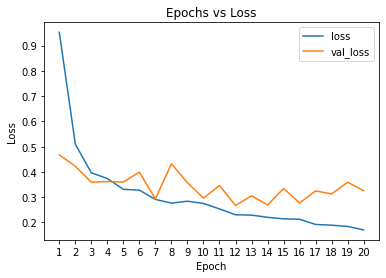

In [12]:
# Here is the code to visualize the loss values
sns.lineplot(x=range(1,21),y=history.history['loss'])
sns.lineplot(x=range(1,21),y=history.history['val_loss'])
plt.legend(loc='upper right',labels=['loss','val_loss'])
plt.title('Epochs vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss') 
plt.xticks(ticks=range(1,21));

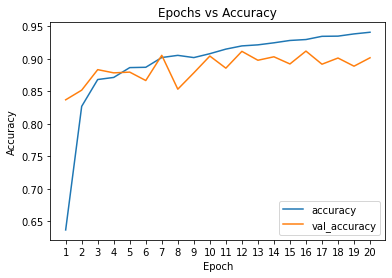

In [13]:
# Here is the code to visualize the accuracy values 
sns.lineplot(x=range(1,21),y=history.history['accuracy'])
sns.lineplot(x=range(1,21),y=history.history['val_accuracy'])
plt.legend(loc='lower right',labels=['accuracy','val_accuracy'])
plt.title('Epochs vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy') 
plt.xticks(ticks=range(1,21));

# Here we are going to visualize some of the response maps from the convolutions. 

In [14]:
# Here we are going to load the best version of the model and look at its convolutional maps
model = tf.keras.models.load_model('best_model.pb')

In [15]:
# Here we are going to use vgg19 directly since we did not train the weights of the model.
viz_conv = Model(inputs=[vgg19.input],outputs=[vgg19.get_layer('block1_conv2').output])

In [18]:
# image we are going to use 
myimg = prepare_image(img_path='/content/drive/MyDrive/MSBA/BA885/data/val/forest/20089.jpg')
features0= viz_conv.predict(myimg)

#### Here we are visualizing the 64 different response maps

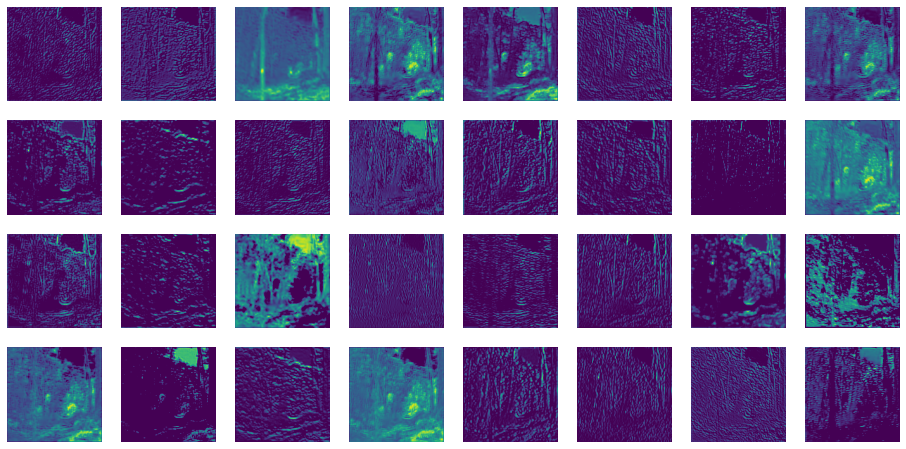

In [19]:
plt.figure(figsize=(16, 8))
N=32
for images in features0:
  for i in range(N):
    plt.subplot(4,8,i+1)
    plt.imshow(features0[0,:,:,i])
    #ax = plt.subplot(3, 3, i + 1)
    #plt.imshow(images[i].astype("uint8"))
    #plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

shape:  (1, 150, 150, 64) 

type:  <class 'numpy.ndarray'> 



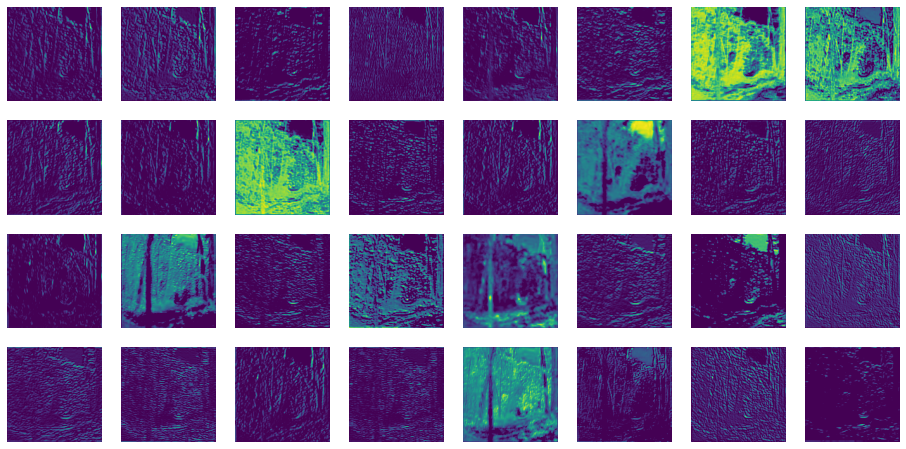

In [20]:
print('shape: ', features0.shape , '\n')
print('type: ',type(features0), '\n')
#Visualize the features
plt.figure(figsize=(16, 8))
N=32
for images in features0:
  for i in range(N):
    plt.subplot(4,8,i+1)
    plt.imshow(features0[0,:,:,i+32])
    #ax = plt.subplot(3, 3, i + 1)
    #plt.imshow(images[i].astype("uint8"))
    #plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

[0. 0. 0. 1. 0. 0.]
True label is: mountain
Predictions:
[8.7289283e-07 4.3202367e-06 1.1746905e-02 9.8824710e-01 7.9058242e-07
 2.3154227e-09]
Predicted label is: mountain


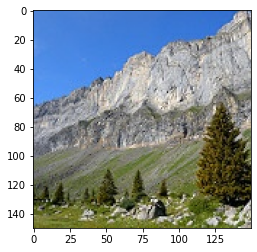

In [21]:
one_batch = next(iter(val_ds_labeled.take(2)))
#the true label
tlabel = one_batch[1][0].numpy()
print(tlabel)
print("True label is: {}".format(val_ds_labeled.class_names[np.argmax(tlabel)]))
#the image
plt.imshow(one_batch[0][0].numpy().astype("uint8"))
#run prediction
predictions = model.predict(one_batch[0])
print("Predictions:")
print(predictions[0])
print("Predicted label is: {}".format(val_ds_labeled.class_names[np.argmax(predictions[0])]))

In [22]:
bad_predictions=[]
for i in range(32):
  tl = np.argmax(one_batch[1][i].numpy())
  pl = np.argmax(predictions[i])
  if int(tl) != int(pl): 
    print("Example {}: True label {} Predicted label {}".format(i, tl,pl))
    bad_predictions.append(i)
print(bad_predictions)

Example 5: True label 2 Predicted label 3
Example 25: True label 2 Predicted label 5
[5, 25]


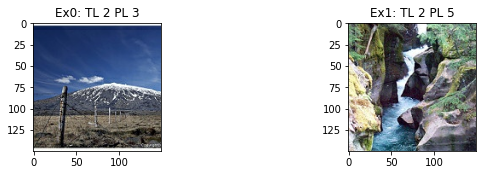

In [23]:
plt.figure(figsize=(16, 8))
for i,j in enumerate(bad_predictions):
  plt.subplot(3,3,i+1)
  plt.imshow(one_batch[0][j].numpy().astype("uint8"))
  plt.title("Ex{}: TL {} PL {}".format(i, np.argmax(one_batch[1][j].numpy()),
                                       np.argmax(predictions[j])))

In [24]:
# Here we are getting our predicted labels in label encoded format 
val_predictions = model.predict(val_ds_labeled)
val_predictions= np.argmax(val_predictions,axis=1)

In [25]:
val_true_labels = []
val_pred_labels = []
for x , y in val_ds_labeled:
  
  y_pred = model.predict_on_batch(x)
  y_pred = np.argmax(y_pred,axis=1).tolist()
  val_pred_labels.extend(y_pred)

  y_ = np.argmax(y,axis=1).tolist()
  val_true_labels.extend(y_)

In [26]:
print(f"Here we are the labels for the following classification report (0,..,5): {val_ds_labeled.class_names}")

Here we are the labels for the following classification report (0,..,5): ['building', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [27]:
print(classification_report(val_true_labels,val_pred_labels))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       392
           1       0.99      0.98      0.98       415
           2       0.90      0.83      0.86       476
           3       0.84      0.91      0.88       476
           4       0.96      0.92      0.94       419
           5       0.91      0.92      0.91       452

    accuracy                           0.91      2630
   macro avg       0.91      0.91      0.91      2630
weighted avg       0.91      0.91      0.91      2630

